# RNN Encoder

RNN model to encode an abstract and predict the gender of the study

In [29]:
%store -r abstracts_w2v_embeddings abstracts_targets_collapsed

### Training Data

In [30]:
X_idxs_ = list(abstracts_targets_collapsed.abstracts_idxed)

ys = abstracts_targets_collapsed.gender

# Binarize ys
num = len(ys.unique())
binarize = {i: label for i, label in zip(ys.unique(), range(num))}
ys = ys.map(binarize)

### Hyperparameters

In [31]:
M, WORD_DIM = abstracts_w2v_embeddings.shape
H, C = 10, len(ys.unique())
LR_ = .005

### Learnable Parameters

In [32]:
W_ = abstracts_w2v_embeddings # word vectors

Wh_ = np.random.uniform(-1, 1, size=[H, H]) # hidden to hidden function
Wx_ = np.random.uniform(-1, 1, size=[WORD_DIM, H]) # input to hidden function
Ws_ = np.random.uniform(-1, 1, size=[H, C]) # softmax function

### Model

In [176]:
import theano.tensor as T
import theano

# Learnable parameters
W = theano.shared(value=W_, name='W')

Wh = theano.shared(value=Wh_, name='Wh') # hidden-hidden function
Wx = theano.shared(value=Wx_, name='Wx') # input-hidden function
Ws = theano.shared(value=Ws_, name='Ws') # softmax

# Inputs
x_idxs = T.ivector('x_idxs') # vector of indices into embedding matrix for current abstract
y = T.iscalar('y') # class number

lr = T.scalar('learning_rate')

# Actual model
x = W[x_idxs] # get the matrix of word vectors corresponding to these indices

def step_forward(x, h_prev, Wh, Wx):
    """Defines one step of an RNN
    
    Parameters
    ----------
    x : element of original sequence passed by scan()
    h_prev : accumulation of result thus far
    Wh, Wx : non-sequences passed in every iteration
    
    Take the input at the current time step, along with the previous hidden state and combine them to produce a new
    hidden state
    
    """
    z = T.dot(h_prev, Wh) + T.dot(x, Wx)
    hidden = T.tanh(z)
    
    return hidden

# Step the RNN though the abstract
hiddens, updates = theano.scan(step_forward, # function to apply at each step in the sequence
                               sequences=x, # sequence to scan() along
                               outputs_info=dict(initial=T.zeros(H)), # tells scan() that we want to be passed in the result of the scan() thus far AND to initialize h0 to zeros
                               non_sequences=[Wh, Wx], # tells scan() to pass in Whh and Wxh at each step
                               strict=True) # tells scan() to throw an error if we're accessing non-local variables in the body of the function

hidden = hiddens[-1] # only consider last hidden state

scores = T.dot(hidden, Ws) # dot encoded abstract with softmax scores
probs = T.nnet.softmax(scores)
prediction = T.argmax(probs, axis=1)
loss = -T.log(probs[0, y])

# Gradients
dWh = T.grad(loss, wrt=Wh)
dWx = T.grad(loss, wrt=Wx)
dWs = T.grad(loss, wrt=Ws)

params, grads = (Wh, Wx, Ws), (dWh, dWx, dWs)

train = theano.function(inputs=[x_idxs, y, lr],
                        outputs=loss,
                        updates=[(param, param - lr*grad) for param, grad in zip(params, grads)])

### Example

In [177]:
def training_example_generator():
    while True:
        for x_idxs, y in zip(X_idxs_, ys):
            yield x_idxs, y

In [178]:
def loss_generator(num_iters):
    example = training_example_generator()

    for i in range(num_iters):
        x_idxs, y = next(example)

        yield train(x_idxs, y, .005)

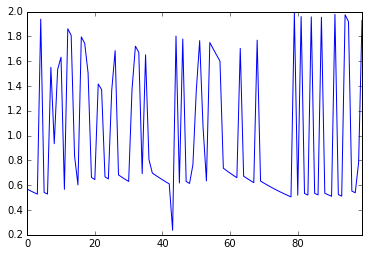

In [189]:
pd.Series([float(loss) for loss in list(loss_generator(100))]).plot()